In [0]:
import numpy as np
import tensorflow as tf
import os
import torch
import math
import torch.nn as nn
from torchvision import transforms
from torch.optim import Adam
from workspace_utils import keep_awake

In [0]:
! pip install pycocotools

# Path Handling


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!ls /content/gdrive/My\ Drive/Udacity-CVND-Image-Captioning-master/*.py

'/content/gdrive/My Drive/Udacity-CVND-Image-Captioning-master/data_loader.py'
'/content/gdrive/My Drive/Udacity-CVND-Image-Captioning-master/data_loader_val.py'
'/content/gdrive/My Drive/Udacity-CVND-Image-Captioning-master/model.py'
'/content/gdrive/My Drive/Udacity-CVND-Image-Captioning-master/vocabulary.py'
'/content/gdrive/My Drive/Udacity-CVND-Image-Captioning-master/workspace_utils.py'


In [0]:
!cat '/content/gdrive/My Drive//Udacity-CVND-Image-Captioning-master/data_loader.py'

import nltk
import os
import torch
import torch.utils.data as data
from vocabulary import Vocabulary
from PIL import Image
from pycocotools.coco import COCO
import numpy as np
from tqdm import tqdm
import random
import json

def get_loader(transform,
               mode='train',
               batch_size=1,
               vocab_threshold=None,
               vocab_file='/content/gdrive/My Drive//Udacity-CVND-Image-Captioning-master/vocab.pkl',
               start_word="<start>",
               end_word="<end>",
               unk_word="<unk>",
               vocab_from_file=True,
               num_workers=0,
               cocoapi_loc='/content/opt'):
               
    """Returns the data loader.
    Args:
      transform: Image transform.
      mode: One of 'train' or 'test'.
      batch_size: Batch size (if in testing mode, must have batch_size=1).
      vocab_threshold: Minimum word count threshold.
      vocab_file: File containing the vocabulary. 
      start_word: Special wor

In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/Udacity-CVND-Image-Captioning-master/')

# Data Preprocessing


In [0]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510574080/13510573713 [==============================] - 691s 0us/step


In [0]:
# Download image files
image_folder = '/test2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('test2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/test2014.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

6660440064/6660437059 [==============================] - 181s 0us/step


In [0]:
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/image_info_test2014.zip',
                                          extract = True)
  # annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

770048/763464 [==============================] - 0s 1us/step


In [0]:
import sys
from pycocotools.coco import COCO
!pip install nltk
import nltk
nltk.download('punkt')
from data_loader import get_loader
from torchvision import transforms

# Define a transform to pre-process the training images.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Set the minimum word count threshold.
vocab_threshold = 5

# Specify the batch size.
batch_size = 10

# Obtain the data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=False)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
/content/opt/cocoapi/annotations/captions_train2014.json
loading annotations into memory...
Done (t=2.54s)
creating index...
index created!
[0/414113] Tokenizing captions...
[100000/414113] Tokenizing captions...
[200000/414113] Tokenizing captions...
[300000/414113] Tokenizing captions...
[400000/414113] Tokenizing captions...
loading annotations into memory...
Done (t=0.79s)
creating index...


  0%|          | 758/414113 [00:00<00:54, 7577.37it/s]

index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [00:57<00:00, 7206.38it/s]


# Data Loader to Obtain Batches

In [0]:
import numpy as np
import torch.utils.data as data

# Randomly sample a caption length, and sample indices with that length.
indices = data_loader.dataset.get_train_indices()
print('sampled indices:', indices)

# Create and assign a batch sampler to retrieve a batch with the sampled indices.
new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
data_loader.batch_sampler.sampler = new_sampler
    
# Obtain the batch.
images, captions = next(iter(data_loader))
    
print('images.shape:', images.shape)
print('captions.shape:', captions.shape)

# (Optional) Uncomment the lines of code below to print the pre-processed images and captions.
# print('images:', images)
# print('captions:', captions)

sampled indices: [180133, 334080, 71831, 9184, 408473, 79811, 208311, 94523, 333896, 74046]
images.shape: torch.Size([10, 3, 224, 224])
captions.shape: torch.Size([10, 11])


# Model


In [0]:
# Watch for any changes in model.py, and re-load it automatically.
% load_ext autoreload
% autoreload 2

# Import EncoderCNN and DecoderRNN. 
from model import EncoderCNN, DecoderRNN

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CNN

In [0]:
# Specify the dimensionality of the image embedding.
embed_size = 256

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Initialize the encoder. (Optional: Add additional arguments if necessary.)
encoder = EncoderCNN(embed_size)

# Move the encoder to GPU if CUDA is available.
encoder.to(device)
    
# Move last batch of images (from Step 2) to GPU if CUDA is available.   
images = images.to(device)

# Pass the images through the encoder.
features = encoder(images)

print('type(features):', type(features))
print('features.shape:', features.shape)

# Check that your encoder satisfies some requirements of the project! :D
assert type(features)==torch.Tensor, "Encoder output needs to be a PyTorch Tensor." 
assert (features.shape[0]==batch_size) & (features.shape[1]==embed_size), "The shape of the encoder output is incorrect."

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth



type(features): <class 'torch.Tensor'>
features.shape: torch.Size([10, 256])


RNN

In [0]:
# Specify the number of features in the hidden state of the RNN decoder.
hidden_size = 512

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Store the size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the decoder.
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Move the decoder to GPU if CUDA is available.
decoder.to(device)
    
# Move last batch of captions (from Step 1) to GPU if CUDA is available 
captions = captions.to(device)

# Pass the encoder output and captions through the decoder.
outputs = decoder(features, captions)

print('type(outputs):', type(outputs))
print('outputs.shape:', outputs.shape)

# Check that your decoder satisfies some requirements of the project! :D
assert type(outputs)==torch.Tensor, "Decoder output needs to be a PyTorch Tensor."
assert (outputs.shape[0]==batch_size) & (outputs.shape[1]==captions.shape[1]) & (outputs.shape[2]==vocab_size), "The shape of the decoder output is incorrect."

type(outputs): <class 'torch.Tensor'>
outputs.shape: torch.Size([10, 11, 8855])


# Training

In [0]:
import nltk
nltk.download('punkt')

import torch
import torch.nn as nn
from torchvision import transforms
import sys
# sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from model import EncoderCNN, DecoderRNN
import math
from torch.optim import Adam
from workspace_utils import keep_awake


## TODO #1: Select appropriate values for the Python variables below.
batch_size = 64          # batch size
vocab_threshold = 5        # minimum word count threshold
vocab_from_file = True     # if True, load existing vocab file
embed_size = 512             # dimensionality of image and word embeddings
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_epochs = 3            # number of training epochs
save_every = 1             # determines frequency of saving model weights
print_every = 100          # determines window for printing average loss
log_file = '/content/gdrive/My Drive/Udacity-CVND-Image-Captioning-master/training_log.txt'       # name of file with saved training loss and perplexity

# (Optional) TODO #2: Amend the image transform below.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Build data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=vocab_from_file)

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder. 
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

# Define the loss function. 
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

# TODO #3: Specify the learnable parameters of the model.
params = list(decoder.parameters()) + list(encoder.embed.parameters())

# TODO #4: Define the optimizer.
optimizer = Adam(params, lr = 0.001)

# Set the total number of training steps per epoch.
total_step = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.77s)
creating index...


  0%|          | 634/414113 [00:00<01:05, 6336.88it/s]

index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [00:59<00:00, 6916.53it/s]


In [0]:
import torch.utils.data as data
import numpy as np
import os
import requests
import time

# num_epochs = 
# Open the training log file.
f = open(log_file, 'w')



for epoch in range(1, num_epochs+1):
    
    for i_step in range(1, total_step+1):
        
        
        
        # Randomly sample a caption length, and sample indices with that length.
        indices = data_loader.dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        data_loader.batch_sampler.sampler = new_sampler
        
        # Obtain the batch.
        images, captions = next(iter(data_loader))

        # Move batch of images and captions to GPU if CUDA is available.
        images = images.to(device)
        captions = captions.to(device)
        
        # Zero the gradients.
        decoder.zero_grad()
        encoder.zero_grad()
        
        # Pass the inputs through the CNN-RNN model.
        features = encoder(images)
        outputs = decoder(features, captions)
        
        # Calculate the batch loss.
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
        
        # Backward pass.
        loss.backward()
        
        # Update the parameters in the optimizer.
        optimizer.step()
            
        # Get training statistics.
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), np.exp(loss.item()))
        
        # Print training statistics (on same line).
        print('\r' + stats, end="")
        sys.stdout.flush()
        
        # Print training statistics to file.
        f.write(stats + '\n')
        f.flush()
        
        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print('\r' + stats)
            
    # Save the weights.
    if epoch % save_every == 0:
        torch.save(decoder.state_dict(), os.path.join('/content/gdrive/My Drive/Udacity-CVND-Image-Captioning-master/', 'decoder-f-%d.pkl' % epoch))
        torch.save(encoder.state_dict(), os.path.join('/content/gdrive/My Drive/Udacity-CVND-Image-Captioning-master/', 'encoder-f-%d.pkl' % epoch))

# Close the training log file.
f.close()

Epoch [1/3], Step [100/6471], Loss: 4.4776, Perplexity: 88.0268
Epoch [1/3], Step [200/6471], Loss: 4.0276, Perplexity: 56.1253
Epoch [1/3], Step [300/6471], Loss: 3.6840, Perplexity: 39.8043
Epoch [1/3], Step [400/6471], Loss: 3.8926, Perplexity: 49.0382
Epoch [1/3], Step [500/6471], Loss: 3.4432, Perplexity: 31.2859
Epoch [1/3], Step [600/6471], Loss: 3.1513, Perplexity: 23.3668
Epoch [1/3], Step [700/6471], Loss: 3.5450, Perplexity: 34.6406
Epoch [1/3], Step [800/6471], Loss: 3.5311, Perplexity: 34.1618
Epoch [1/3], Step [900/6471], Loss: 3.0672, Perplexity: 21.4807
Epoch [1/3], Step [1000/6471], Loss: 3.2694, Perplexity: 26.2952
Epoch [1/3], Step [1100/6471], Loss: 3.2391, Perplexity: 25.5108
Epoch [1/3], Step [1200/6471], Loss: 2.8444, Perplexity: 17.1917
Epoch [1/3], Step [1300/6471], Loss: 2.9881, Perplexity: 19.8479
Epoch [1/3], Step [1400/6471], Loss: 2.9023, Perplexity: 18.2151
Epoch [1/3], Step [1500/6471], Loss: 3.3028, Perplexity: 27.1893
Epoch [1/3], Step [1600/6471], Los

# Predict


In [0]:
import sys
# sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms

# TODO #1: Define a transform to pre-process the testing images.
transform_test = transforms.Compose([ 
    transforms.Resize((224,224)),                          # smaller edge of image resized to 256
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Create the data loader.
data_loader = get_loader(transform=transform_test,    
                         mode='test')

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Obtain sample image before and after pre-processing.
orig_image, image = next(iter(data_loader))

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

In [0]:
# Watch for any changes in model.py, and re-load it automatically.
% load_ext autoreload
% autoreload 2

import os
import torch
from model import EncoderCNN, DecoderRNN

# TODO #2: Specify the saved models to load.
encoder_file = 'encoder-3.pkl' 
decoder_file = 'decoder-3.pkl'

# TODO #3: Select appropriate values for the Python variables below.
embed_size = 300
hidden_size = 128

# The size of the vocabulary.
# vocab_size = len(data_loader.dataset.vocab)
vocab_size =8855
print(vocab_size)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('/content/gdrive/My Drive/Udacity-CVND-Image-Captioning-master/', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('/content/gdrive/My Drive/Udacity-CVND-Image-Captioning-master/', decoder_file)))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

In [0]:
# Move image Pytorch Tensor to GPU if CUDA is available.
image = image.to(device)

# Obtain the embedded image features.
print(image.shape)
features = encoder(image).unsqueeze(1)

# Pass the embedded image features through the model to get a predicted caption.
output = decoder.sample(features)
print('example output:', output)

assert (type(output)==list), "Output needs to be a Python list" 
assert all([type(x)==int for x in output]), "Output should be a list of integers." 
assert all([x in data_loader.dataset.vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

In [0]:
# TODO #4: Complete the function.
def clean_sentence(output):
    sentence = ''
    for x in output:
        sentence = sentence + ' ' + data_loader.dataset.vocab.idx2word[x]
        sentence = sentence.strip()
    return sentence

In [0]:
def get_prediction(image_path):
    image = Image.open(image_path)
    plt.imshow(np.squeeze(image))
    plt.title('Sample Image')
    plt.show()
    image = ToTensor()(image).unsqueeze(0)
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)
    return sentence[7:-6]

# Image to text

In [0]:
!sudo apt install tesseract-ocr
!sudo pip install pytesseract


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 29 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (4,586 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [0]:
from PIL import Image
import PIL.Image
from pytesseract import image_to_string
import pytesseract

In [0]:
pytesseract.pytesseract.tesseract_cmd = (
    r"/usr/bin/tesseract"
)

In [0]:
def text_in_image( image_path):
  return pytesseract.image_to_string(Image.open(image_path))

# Text to voice

In [0]:
pip install gtts

  Created wheel for gtts-token: filename=gTTS_token-1.1.3-cp36-none-any.whl size=4097 sha256=6fda89d7964936406bf0291f6c8eb04182132d0886ea825261dca84c1f1eb8fc
  Stored in directory: /root/.cache/pip/wheels/dd/11/61/33f7e51bf545e910552b2255eead2a7cd8ef54064b46dceb34
Successfully built gtts-token


In [0]:
from gtts import gTTS 
from IPython.display import Audio
import os 
  

In [0]:
def text_to_voice( text , language ):
  voice = gTTS(text=text, lang=language, slow=False) 
  voice.save("voice.mp3")
  sound_file = 'voice.mp3'
  return sound_file


In [0]:
out =  text_in_image('/content/duarte_slide_8-thumb-580x416-2552.jpg')
x = text_to_voice(out , 'en')
Audio(x, autoplay=True) 

# Vedio preprocessing


# Main

In [0]:
#1
image_path = '/content/index.jpeg'
# image_path ='/content/t3qWG.png'
# image_path = '/content/final-result.jpg'
#2
out_1 =  text_in_image(image_path)
print(out_1)
#3
out_2  = get_prediction(image_path)
print(out_2)
#4
out = out_1 + out_2
x = text_to_voice(out , 'en')

#5
Audio(x, autoplay=True) 

NameError: ignored

In [0]:
from PIL import Image
import PIL.Image
from torchvision.transforms import *
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import tensorflow as tf
import os
import torch
import math
%matplotlib inline

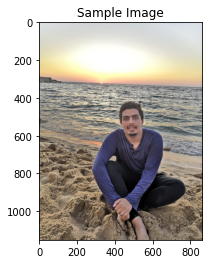

<start> a person on a surfboard riding a wave . <end>
 a person on a surfboard riding a wave .


In [0]:
image_path ='/content/IMG-20190809-WA0011.jpg'
out_2  = get_prediction(image_path)
print(out_2)
#4